In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
dataset = pd.read_csv("https://drive.google.com/uc?export=download&id=1KvxyyF3QCtvIx0J7_8iWDEtFQpLgd0Yq")

In [3]:
dataset.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


##### Firstly, let’s inspect the data to look for weird behavior/wrong data. Data is never perfect in real life and requires to be cleaned. Identifying the wrong data and dealing with it is a crucial step

Describe and groupby are usually the best places to start:

In [4]:
dataset.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [5]:
dataset = dataset[dataset["age"] < 110]

In [6]:
dataset.groupby(["source"]).size()

source
Ads        88739
Direct     72420
Seo       155039
dtype: int64

In [7]:
dataset.groupby(["country"]).size()

country
China       76602
Germany     13055
UK          48449
US         178092
dtype: int64

#### A few quick observations:

the site is probably a US site, although it does have a large Chinese user base as well

user base is pretty young

conversion rate at around 3% is industry standard. It makes sense

everything seems to make sense here except for max age 123 yrs! Let’s investigate it:

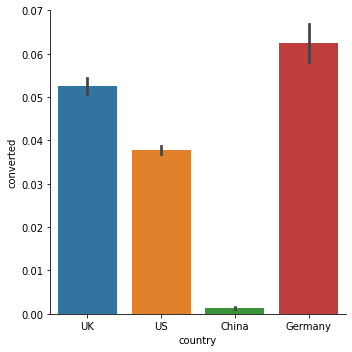

In [8]:
sns.catplot(x="country", y="converted", data=dataset, kind="bar")

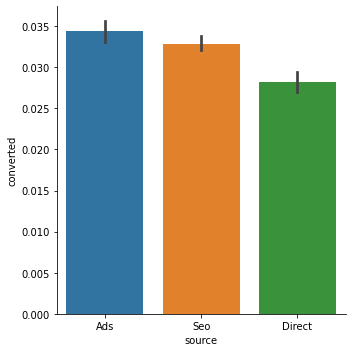

In [9]:
sns.catplot(x="source",y="converted",data=dataset, kind="bar")

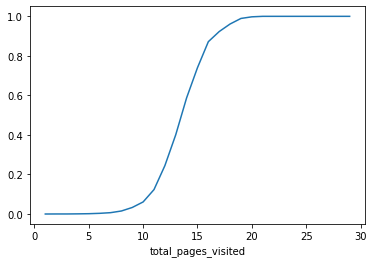

In [10]:
dataset.groupby(["total_pages_visited"])["converted"].mean().plot()

## Machine Learning

In [11]:
# Firstly, let’s create dummy variables from the categorical ones

dataset_dummy = pd.get_dummies(dataset,drop_first=True)

In [12]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset_dummy, test_size=0.34)

In [13]:
# IMPORTATION DE RANDOM FORREST ET DE NOTRE METRIC

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [16]:
rd_clf = RandomForestClassifier(n_estimators=300, max_features=3, oob_score=True)
rd_clf.fit(train.drop("converted", axis=1), train["converted"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [20]:
print("OOB_score is",
      rd_clf.oob_score_,
      "\n",
      "OOB Confusion Matrix",
      "\n",
      pd.DataFrame(confusion_matrix(train['converted'], rd_clf.oob_decision_function_[:,1].round(), labels=[0, 1]))
      )

OOB_score is 0.9843883271838613 
 OOB Confusion Matrix 
         0     1
0  200887  1056
1    2202  4545


### and let's print test accuracy and confusion matrix

In [36]:
print(
"Test accuracy is", rd_clf.score(test.drop('converted', axis=1), test['converted']),
"\n",
"Test Set Confusion Matrix",
"\n",
pd.DataFrame(confusion_matrix(test['converted'],rd_clf.predict(test.drop('converted',axis=1)), labels=[0,1])))     


Test accuracy is 0.9850150686460543 
 Test Set Confusion Matrix 
         0     1
0  103560   497
1    1114  2337


### So, OOB error and test error are pretty similar, ~1.5%. We are confident we are not overfitting.

Error is pretty low. However, we started from a 97% accuracy (that’s the case if we classified everything as a “non converted”). So, 98.5% is good, but nothing shocking. Indeed, ~30% of conversions are predicted as “non conversion”.

If we cared about the very best possible accuracy or specifically minimizing false positive/false negative, we would find the best cut-off point. Since in this case that doesn’t appear to be particularly relevant, we are fine with the default 0.5 cutoff value used internally by the random forest to make the prediction.

If you care about insights, building a model is just the first step. You need to check that the model predicts well and, if it does, you can now extract insights out of it.

Let’s start by checking variable importance:

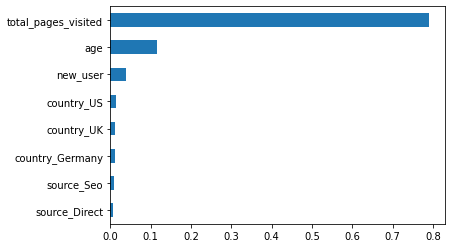

In [39]:
feat_importances = pd.Series(rd_clf.feature_importances_, index=train.drop('converted', axis=1).columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

#### Total pages visited is the most important one, by far. Unfortunately, it is probably the least “actionable”. People visit many pages because they already want to buy. Also, in order to buy, you have to click on multiple pages. Let’s rebuild the RF without that variable. Since classes are heavily unbalanced and we don’t have that very powerful variable anymore, let’s change the weights, just to make sure we will get something classified as 1.

In [43]:
rd_clf = RandomForestClassifier(n_estimators=100,max_features=3,oob_score=True, class_weight={0:1,1:10})
rd_clf.fit(train.drop(['converted','total_pages_visited'], axis=1),train['converted'])

print(
    'OOB accuracy is',
    rd_clf.oob_score_,
    "/n",
    "OOB Confusion Matrix",
    "/n",
    pd.DataFrame(confusion_matrix(train["converted"],rd_clf.oob_decision_function_[:,1].round(), labels=[0,1]))
)

OOB accuracy is 0.8897886817767982 /n OOB Confusion Matrix /n         0      1
0  182654  19289
1    3711   3036


In [47]:
#and let's print test accuracy and confusion matrix
print(
"Test accuracy is", rd_clf.score(test.drop(['converted', 'total_pages_visited'], axis=1),test['converted']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(test['converted'], rd_clf.predict(test.drop(['converted', 'total_pages_visited'], axis=1)), labels=[0, 1]))
)

Test accuracy is 0.8917196859768576 
 Test Set Confusion Matrix 
        0     1
0  94337  9720
1   1921  1530


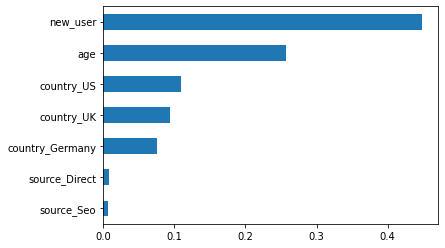

In [48]:
feat_importances = pd.Series(rd_clf.feature_importances_, index=train.drop(['converted', 'total_pages_visited'], axis=1).columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

### Interesting! New user is the most important one, even more important than age. And that’s impressive given that we know how continuous variables tend to always show up at the top in RF variable importance plots. It means new_user is really important. Source-related dummies don’t seem to matter at all.

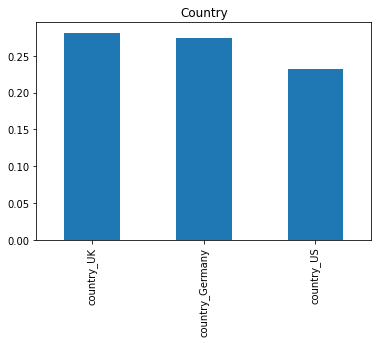

In [50]:
!pip install pdpbox
from pdpbox import pdp, info_plots

#country
pdp_iso = pdp.pdp_isolate( model=rd_clf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature=['country_Germany', 'country_UK', 'country_US'], 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Country')
plt.show()


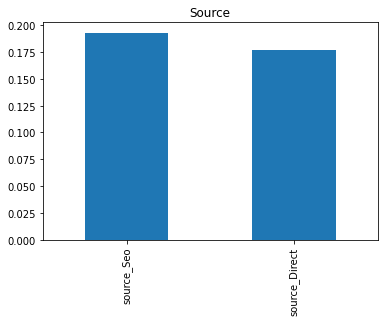

In [51]:
#source
pdp_iso = pdp.pdp_isolate( model=rd_clf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature=['source_Direct', 'source_Seo'], 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Source')
plt.show()

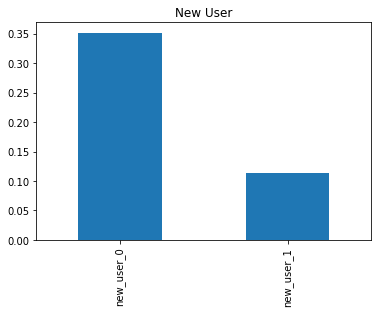

In [52]:
#new user
pdp_iso = pdp.pdp_isolate( model=rd_clf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature='new_user', 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='New User')
plt.show()


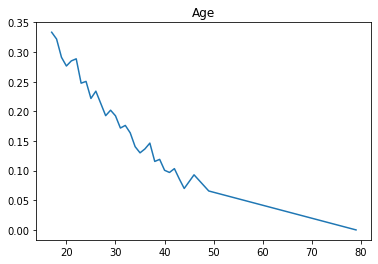

In [53]:
#age
pdp_iso = pdp.pdp_isolate( model=rd_clf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature='age', 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.plot(title='Age')
plt.show()

### This shows that:

Users with an old account are much better than new users

Germany, UK, and US are similar, with Germany being the best. Most importantly, they all have very very high values. As usual, we have to read this as relative to the reference level, which is China. So this means that not being from China and being from any of those 3 countries significantly increases the probability of conversion. That is, China is very bad for conversion

The site works very well for young people and gets worse for older people

Source is less relevant

Let’s now build a simple decision tree and check the 2 or 3 most important segments:

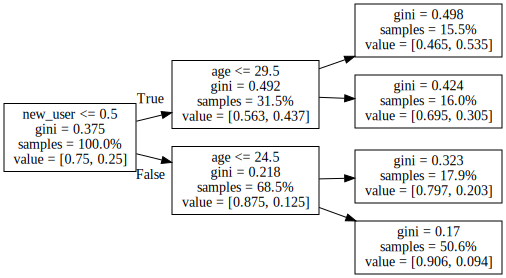

In [54]:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

tree = DecisionTreeClassifier( max_depth=2,class_weight={0:1, 1:10}, min_impurity_decrease = 0.001)
tree.fit(train.drop(['converted', 'total_pages_visited'], axis=1), train['converted'])
  
#visualize it
dot_data = export_graphviz(tree, out_file=None, feature_names=train.drop(['converted', 'total_pages_visited'], axis=1).columns, proportion=True, rotate=True)
graph = graphviz.Source(dot_data)

graph